# Walmart Black Friday Purchase Behaviour Analysis

## Problem Statement

Walmart is a leading American multinational retail corporation that operates a chain of supercenters, discount department stores, and grocery stores. The management team wants to understand **customer purchase behaviour** on **Black Friday**, focusing on how the **purchase amount** varies with:

- Gender (Male vs Female)
- Marital Status (Married vs Unmarried)
- Age groups (life-stage based)

They are particularly interested in answering:

- Do women spend more money per transaction than men on Black Friday?
- How different are the average spends for:
  - Male vs Female customers
  - Married vs Unmarried customers
  - Different age groups (0–17, 18–25, 26–35, 36–50, 51+)
- Can we use a **sample** of transactions to estimate the **population average spending** for:
  - 50 million male customers
  - 50 million female customers

We will:

1. Perform **Exploratory Data Analysis (EDA)**:
   - Understand data structure, types, summary statistics
   - Check for missing values and outliers
   - Plot univariate and bivariate relationships

2. Apply the **Central Limit Theorem (CLT)**:
   - Use **sample means** to estimate the **population mean**
   - Construct **confidence intervals (CIs)** (90%, 95%, 99%) for:
     - Male vs Female spending
     - Married vs Unmarried spending
     - Different Age groups

3. Provide **business insights and simple, actionable recommendations** for Walmart’s marketing and promotional strategy on Black Friday.

_Assumption_: The dataset is a sample of transactions drawn from a much larger population (550K male and female Black Friday customers). We will use CLT to generalize insights from the sample to this population.

## Data Import and Setup

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [86]:
df = pd.read_csv('walmart_data.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


## Basic Data Exploration

In this section we will:
- Check the shape and structure of the dataset
- Inspect data types
- Look at basic statistical summary
- Convert appropriate columns to categorical types

In [87]:
df.shape

(550068, 10)

In [88]:
df.columns.to_list()

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category',
 'Purchase']

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [90]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


In [91]:
df.describe(include='object')

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


In [92]:
# Check unique values for each column (non-graphical analysis)
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].nunique(), "unique values")
    print(df[col].unique()[:10])


Column: User_ID
5891 unique values
[1000001 1000002 1000003 1000004 1000005 1000006 1000007 1000008 1000009
 1000010]

Column: Product_ID
3631 unique values
['P00069042' 'P00248942' 'P00087842' 'P00085442' 'P00285442' 'P00193542'
 'P00184942' 'P00346142' 'P0097242' 'P00274942']

Column: Gender
2 unique values
['F' 'M']

Column: Age
7 unique values
['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']

Column: Occupation
21 unique values
[10 16 15  7 20  9  1 12 17  0]

Column: City_Category
3 unique values
['A' 'C' 'B']

Column: Stay_In_Current_City_Years
5 unique values
['2' '4+' '3' '1' '0']

Column: Marital_Status
2 unique values
[0 1]

Column: Product_Category
20 unique values
[ 3  1 12  8  5  4  2  6 14 11]

Column: Purchase
18105 unique values
[ 8370 15200  1422  1057  7969 15227 19215 15854 15686  7871]


In [93]:
# Convert suitable columns to category dtype for memory & clarity
cat_cols = ["User_ID", "Product_ID", "Gender", "Age", "City_Category", "Stay_In_Current_City_Years",
            "Marital_Status"]

for col in cat_cols:
    df[col] = df[col].astype("category")

df.dtypes

User_ID                       category
Product_ID                    category
Gender                        category
Age                           category
Occupation                       int64
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                category
Product_Category                 int64
Purchase                         int64
dtype: object

## Missing Value and Outlier Detection

We will:
- Detect missing values using `isnull()`
- Use `describe()` and boxplots to inspect outliers in `Purchase`
- Comment on the distribution using mean vs median

In [94]:
# Missing value count
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

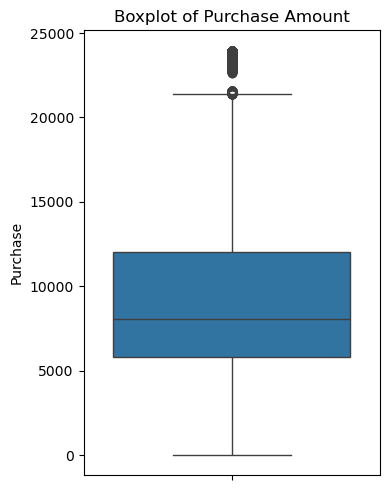

In [95]:
# Boxplot for Purchase to detect outliers
plt.figure(figsize=(4, 5))
sns.boxplot(y=df["Purchase"])
plt.title("Boxplot of Purchase Amount")
plt.tight_layout()
plt.show()

In [96]:
# Check mean vs median for Purchase

print(f"Purchase Mean: {df["Purchase"].mean():.2f}")
print(f"Purchase Median: {df["Purchase"].median():.2f}")
print(f"Purchase Std: {df["Purchase"].std():.2f}")

Purchase Mean: 9263.97
Purchase Median: 8047.00
Purchase Std: 5023.07


### *Observations (to fill after running)

- Comment on amount and pattern of missing values.
- If product category columns have missing values, mention whether you:
  - Dropped them, or
  - Imputed with a value (e.g., 0 or mode).
- Comment on outliers in `Purchase` based on the boxplot:
  - Are there many extreme high values?
  - Does the distribution look right-skewed?

## Univariate Analysis

We will explore distributions of:
- `Purchase` (continuous)
- Categorical variables: `Gender`, `Marital_Status`, `Age`, `City_Category`, etc.

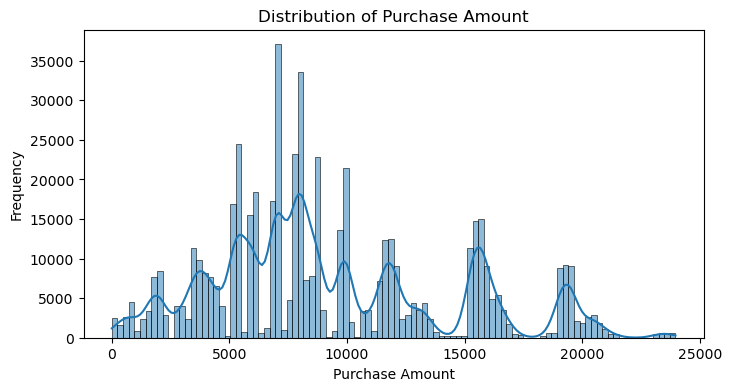

In [97]:
# Distribution of Purchase
plt.figure(figsize=(8, 4))
sns.histplot(df["Purchase"], bins=100, kde=True)
plt.title("Distribution of Purchase Amount")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()

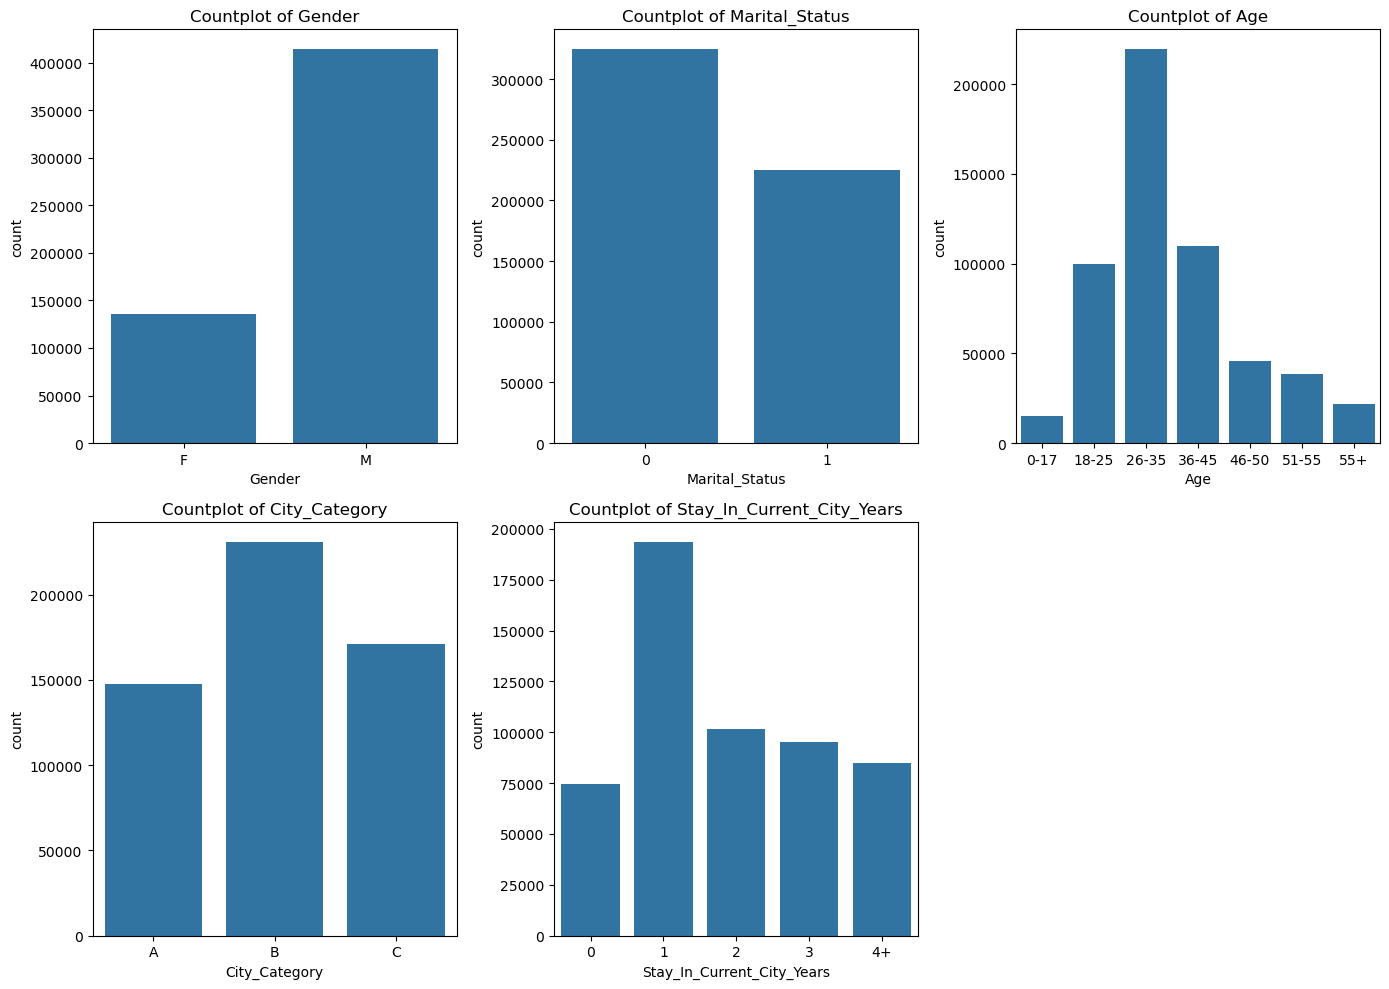

In [98]:
# Countplots for key categorical variables
cat_for_plot = ["Gender", "Marital_Status", "Age", "City_Category", "Stay_In_Current_City_Years"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(cat_for_plot, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=df[col])
    plt.title(f"Countplot of {col}")
    plt.xticks()
plt.tight_layout()
plt.show()

### *Univariate Observations (to fill after running)

- **Purchase**:
  - Is it right-skewed (long tail of high purchasers)?
  - Typical spending range (min, max, quartiles).
- **Gender**:
  - Proportion of male vs female transactions in the dataset.
- **Age**:
  - Which age groups have more transactions?
- **Marital_Status**:
  - Share of married vs unmarried customers.
- **City_Category & StayInCurrentCityYears**:
  - Which city type contributes most transactions?
  - Are more transactions coming from customers with longer stay?

## Bivariate Analysis

We focus on how **Purchase** varies with:
- Gender
- Marital Status
- Age groups
- City category

We use:
- Boxplots to see distribution differences
- Barplots of mean purchase amount
- Correlation for numeric variables

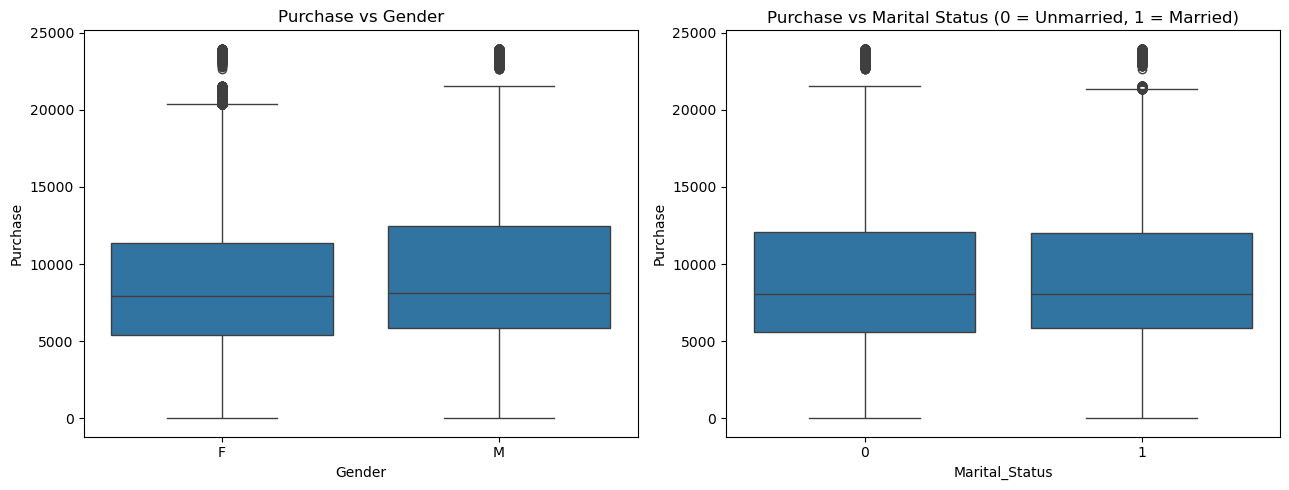

In [118]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="Gender", y="Purchase", data=df)
plt.title("Purchase vs Gender")

plt.subplot(1, 2, 2)
sns.boxplot(x="Marital_Status", y="Purchase", data=df)
plt.title("Purchase vs Marital Status (0 = Unmarried, 1 = Married)")
plt.tight_layout()
plt.show()

In [100]:
# Mean purchase by gender and marital status
print("Mean Purchase by Gender:")
print(df.groupby("Gender")["Purchase"].mean().round(3))

print("\nMean Purchase by Marital Status (0=Unmarried, 1=Married):")
print(df.groupby("Marital_Status")["Purchase"].mean().round(3
                                                           ))

Mean Purchase by Gender:
Gender
F    8734.566
M    9437.526
Name: Purchase, dtype: float64

Mean Purchase by Marital Status (0=Unmarried, 1=Married):
Marital_Status
0    9265.908
1    9261.175
Name: Purchase, dtype: float64


/var/folders/4v/r1w5g21146388lqn4pyhv1640000gn/T/ipykernel_17527/1093211803.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Gender")["Purchase"].mean().round(3))
/var/folders/4v/r1w5g21146388lqn4pyhv1640000gn/T/ipykernel_17527/1093211803.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Marital_Status")["Purchase"].mean().round(3))


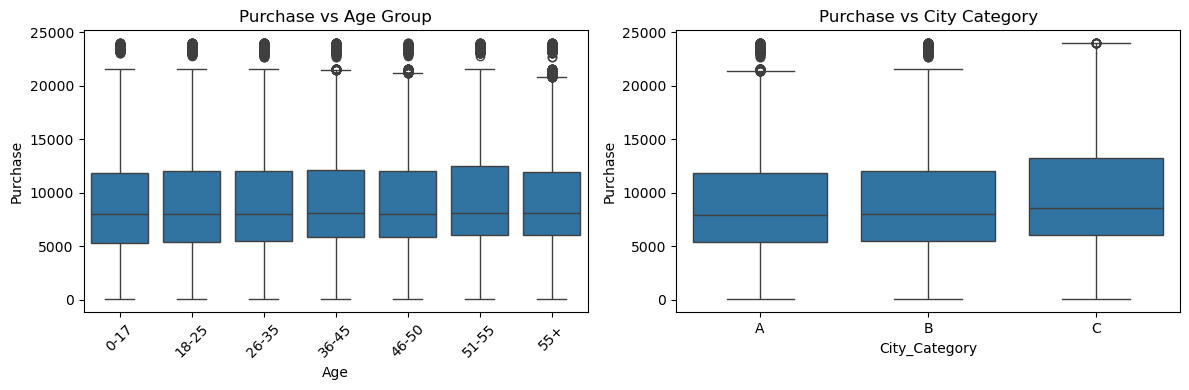

In [101]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x="Age", y="Purchase", data=df, order=sorted(df["Age"].unique()))
plt.title("Purchase vs Age Group")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="City_Category", y="Purchase", data=df)
plt.title("Purchase vs City Category")

plt.tight_layout()
plt.show()

In [102]:
print("Mean Purchase by Age Group:")
print(df.groupby("Age")["Purchase"].mean().sort_index().round(3))

Mean Purchase by Age Group:
Age
0-17     8933.465
18-25    9169.664
26-35    9252.691
36-45    9331.351
46-50    9208.626
51-55    9534.808
55+      9336.280
Name: Purchase, dtype: float64


/var/folders/4v/r1w5g21146388lqn4pyhv1640000gn/T/ipykernel_17527/1777162897.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Age")["Purchase"].mean().sort_index().round(3))


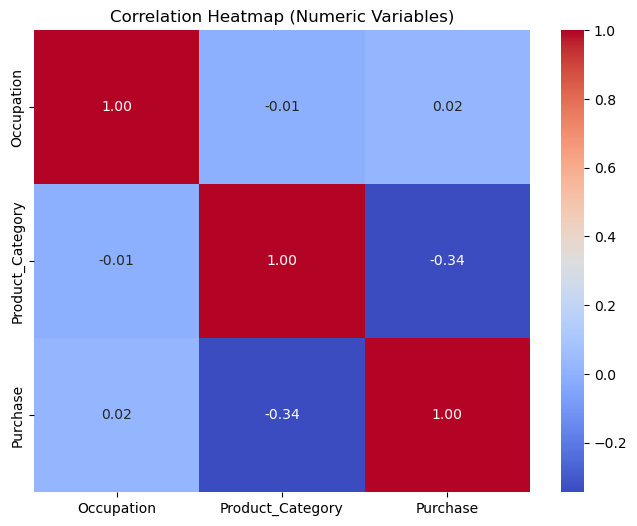

In [104]:
# Select numeric columns for correlation
num_cols = df.select_dtypes(include=["int64"]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()

### *Bivariate Observations (to fill after running)

- **Gender vs Purchase**:
  - Which gender has a higher average purchase per transaction?
  - Are boxplots overlapping heavily or is there a visible shift?

- **Marital_Status vs Purchase**:
  - Do married customers spend more or less per transaction?

- **Age vs Purchase**:
  - Which age bins have the highest average spending?
  - Are younger or mid-age groups more valuable?

- **City_Category vs Purchase**:
  - Which city category shows higher average purchase?

- **Correlation**:
  - How strongly is `Purchase` correlated with `Occupation`, `Age`, etc.?
  - Any surprisingly strong or weak correlations?

## Central Limit Theorem and Confidence Intervals

In [106]:
# *
def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data.dropna())
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = stats.t.ppf((1 + confidence) / 2, n - 1) * sem
    return mean, mean - h, mean + h

### Gender-wise Confidence Intervals

We now estimate confidence intervals of **average purchase per transaction** for:
- Female customers
- Male customers

This allows us to generalize from the sample to the population (50M male & 50M female).

In [107]:
female_purchase = df.loc[df["Gender"] == "F", "Purchase"]
male_purchase   = df.loc[df["Gender"] == "M", "Purchase"]

for conf in [0.90, 0.95, 0.99]:
    f_mean, f_low, f_high = mean_confidence_interval(female_purchase, confidence=conf)
    m_mean, m_low, m_high = mean_confidence_interval(male_purchase, confidence=conf)

    print(f"\nConfidence Level: {int(conf*100)}%")
    print(f"Female mean: {f_mean:.2f}, CI: [{f_low:.2f}, {f_high:.2f}]")
    print(f"Male   mean: {m_mean:.2f}, CI: [{m_low:.2f}, {m_high:.2f}]")


Confidence Level: 90%
Female mean: 8734.57, CI: [8713.29, 8755.84]
Male   mean: 9437.53, CI: [9424.51, 9450.54]

Confidence Level: 95%
Female mean: 8734.57, CI: [8709.21, 8759.92]
Male   mean: 9437.53, CI: [9422.02, 9453.03]

Confidence Level: 99%
Female mean: 8734.57, CI: [8701.24, 8767.89]
Male   mean: 9437.53, CI: [9417.15, 9457.91]


#### *Interpretation Notes (to fill after running)

- Compare **female mean** and **male mean**.
- Check if their **95% CIs overlap**:
  - If CIs **do not overlap much**, there is strong evidence of a difference in average spending.
  - If CIs **strongly overlap**, the difference may not be statistically significant.

Use wording like:

> “At 95% confidence, average female spending lies between X and Y, and average male spending lies between A and B. The intervals (do/do not) overlap, suggesting that women (do/do not) spend more per transaction than men on Black Friday in this sample.”

### Central Limit Theorem – Sampling Distribution of Mean

We now:
- Draw repeated random samples of different sizes (e.g., 30, 100, 500, 1000)  
- Compute sample means for Male and Female separately  
- Visualize the distribution of these sample means  
- Observe how the distribution becomes more **normal** and **tighter** as sample size increases

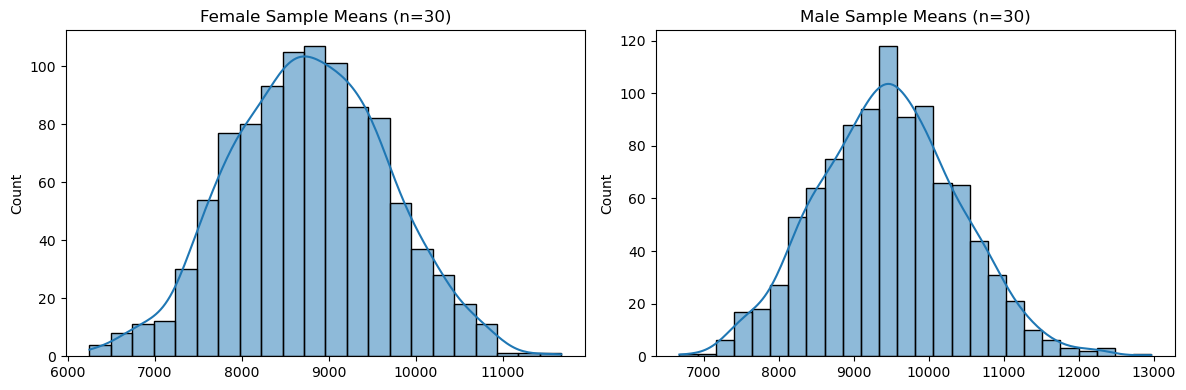

Sample size 30:
Female mean of means: 8777.74, std: 885.91
Male   mean of means: 9458.45, std: 931.51


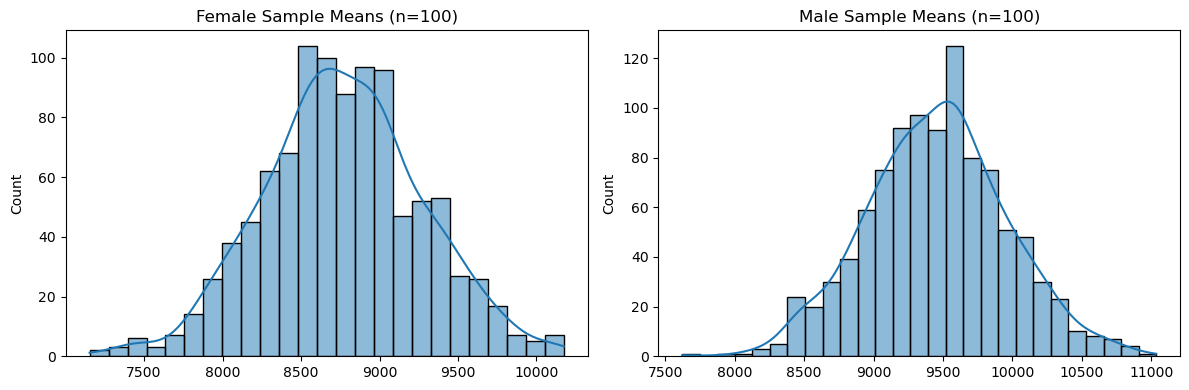

Sample size 100:
Female mean of means: 8766.33, std: 503.70
Male   mean of means: 9455.52, std: 502.39


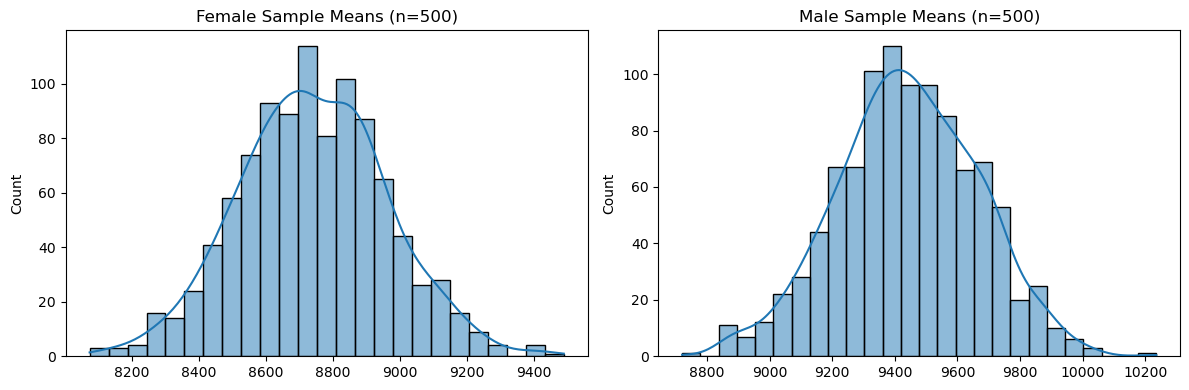

Sample size 500:
Female mean of means: 8740.56, std: 220.12
Male   mean of means: 9441.79, std: 224.42


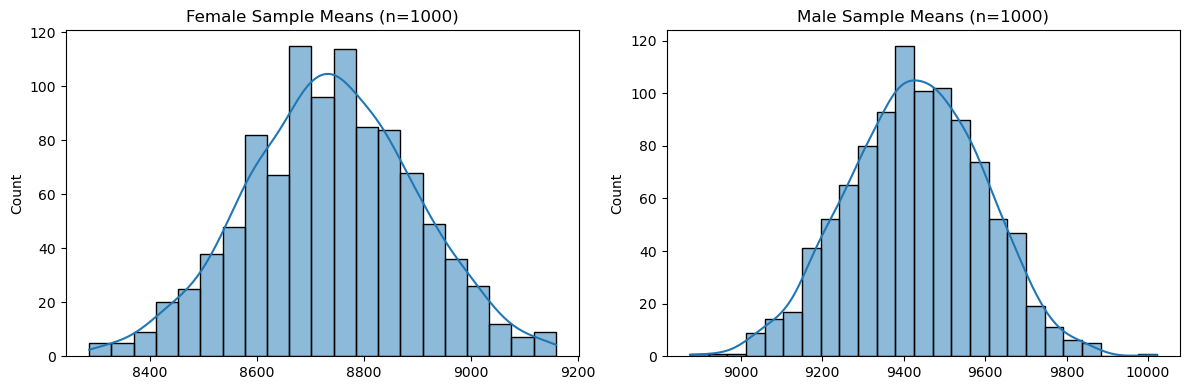

Sample size 1000:
Female mean of means: 8738.74, std: 157.10
Male   mean of means: 9429.51, std: 165.04


In [108]:
def simulate_sample_means(data, sample_size=30, n_samples=1000, random_state=42):
    np.random.seed(random_state)
    data = np.array(data.dropna())
    means = []
    for _ in range(n_samples):
        sample = np.random.choice(data, size=sample_size, replace=True)
        means.append(np.mean(sample))
    return np.array(means)

sample_sizes = [30, 100, 500, 1000]

for n in sample_sizes:
    female_means = simulate_sample_means(female_purchase, sample_size=n)
    male_means   = simulate_sample_means(male_purchase, sample_size=n)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(female_means, kde=True)
    plt.title(f"Female Sample Means (n={n})")

    plt.subplot(1, 2, 2)
    sns.histplot(male_means, kde=True)
    plt.title(f"Male Sample Means (n={n})")

    plt.tight_layout()
    plt.show()

    print(f"Sample size {n}:")
    print(f"Female mean of means: {female_means.mean():.2f}, std: {female_means.std():.2f}")
    print(f"Male   mean of means: {male_means.mean():.2f}, std: {male_means.std():.2f}")

#### *CLT Observations (to fill)

- As sample size **increases**, the distribution of sample means:
  - Becomes **more symmetric & bell-shaped** (normal-like).
  - Has **smaller spread** (standard deviation decreases).
- This supports the **Central Limit Theorem**, which justifies using normal-based confidence intervals for large samples.

### Married vs Unmarried – Confidence Intervals

In [111]:
unmarried_purchase = df.loc[df["Marital_Status"] == 0, "Purchase"]
married_purchase   = df.loc[df["Marital_Status"] == 1, "Purchase"]

for conf in [0.90, 0.95, 0.99]:
    u_mean, u_low, u_high = mean_confidence_interval(unmarried_purchase, confidence=conf)
    mar_mean, mar_low, mar_high = mean_confidence_interval(married_purchase, confidence=conf)

    print(f"\nConfidence Level: {int(conf*100)}%")
    print(f"Unmarried mean: {u_mean:.2f}, CI: [{u_low:.2f}, {u_high:.2f}]")
    print(f"Married   mean: {mar_mean:.2f}, CI: [{mar_low:.2f}, {mar_high:.2f}]")


Confidence Level: 90%
Unmarried mean: 9265.91, CI: [9251.40, 9280.42]
Married   mean: 9261.17, CI: [9243.79, 9278.56]

Confidence Level: 95%
Unmarried mean: 9265.91, CI: [9248.62, 9283.20]
Married   mean: 9261.17, CI: [9240.46, 9281.89]

Confidence Level: 99%
Unmarried mean: 9265.91, CI: [9243.18, 9288.63]
Married   mean: 9261.17, CI: [9233.95, 9288.40]


#### Interpretation Notes

- Compare **married vs unmarried** means and their CIs.
- Comment whether married customers spend significantly more or less.
- Check CI overlap and mirror the same logic as Gender.

### Age-wise Analysis with Life-stage Bins

In [112]:
# Map original Age to life-stage bins
age_map = {
    "0-17": "0-17",
    "18-25": "18-25",
    "26-35": "26-35",
    "36-45": "36-50",
    "46-50": "36-50",
    "51-55": "51+",
    "55+": "51+"
}

df["Age_LifeStage"] = df["Age"].map(age_map)
df["Age_LifeStage"] = df["Age_LifeStage"].astype("category")

df["Age_LifeStage"].value_counts()

Age_LifeStage
26-35    219587
36-50    155714
18-25     99660
51+       60005
0-17      15102
Name: count, dtype: int64

In [114]:
# Mean purchase by life-stage age bin
df.groupby("Age_LifeStage")["Purchase"].mean().sort_index().round(3)

/var/folders/4v/r1w5g21146388lqn4pyhv1640000gn/T/ipykernel_17527/2222255477.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Age_LifeStage")["Purchase"].mean().sort_index().round(3)


Age_LifeStage
0-17     8933.465
18-25    9169.664
26-35    9252.691
36-50    9295.332
51+      9463.662
Name: Purchase, dtype: float64

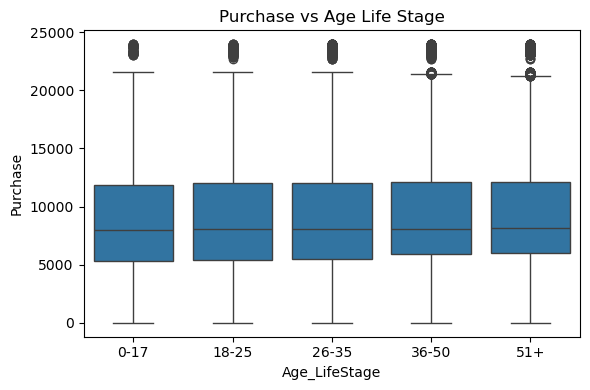

In [116]:
# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x="Age_LifeStage", y="Purchase", data=df,
            order=["0-17", "18-25", "26-35", "36-50", "51+"])
plt.title("Purchase vs Age Life Stage")
plt.tight_layout()
plt.show()

In [119]:
# Confidence intervals by Age_LifeStage at 95%
for age_bin in ["0-17", "18-25", "26-35", "36-50", "51+"]:
    data_bin = df.loc[df["Age_LifeStage"] == age_bin, "Purchase"]
    mean, low, high = mean_confidence_interval(data_bin, confidence=0.95)
    print(f"{age_bin}: mean={mean:.2f}, 95% CI=[{low:.2f}, {high:.2f}]")

0-17: mean=8933.46, 95% CI=[8851.94, 9014.99]
18-25: mean=9169.66, 95% CI=[9138.41, 9200.92]
26-35: mean=9252.69, 95% CI=[9231.73, 9273.65]
36-50: mean=9295.33, 95% CI=[9270.46, 9320.20]
51+: mean=9463.66, 95% CI=[9423.17, 9504.16]


#### Interpretation Notes

- Which life-stage has the **highest average spending**?
- How wide are the CIs for each age group?
  - Smaller sample groups ⇒ wider intervals.
- For planning marketing, age groups with **high mean and relatively tight CIs** are strong target segments.

## Final Insights (Based on EDA & CLT)

> **Note**: Fill in with your actual numeric findings after running the notebook.

### Gender

- Average female spending per transaction: around **X** with 95% CI [Y, Z].
- Average male spending per transaction: around **A** with 95% CI [B, C].
- The confidence intervals for male and female spending **(overlap / do not overlap)**.
  - If **non-overlapping or weakly overlapping**:
    - There is statistically significant evidence that **(women/men)** spend more.
  - If **strongly overlapping**:
    - Differences in mean spending are not statistically strong.

### Marital Status

- Married customers spend on average **...**, with CI [...].
- Unmarried customers spend **...**, with CI [...].
- Comment whether one group consistently spends more and whether the CIs overlap.

### Age Life Stages

- Age group **XYZ** (e.g., 26–35 or 36–50) shows the **highest average spending**.
- Younger (0–17) and older (51+) groups may show lower average spending or fewer transactions.
- CIs show how stable these age-based differences are.

### Other Insights

- Specific city categories may show higher spending or more transactions.
- Occupation or years in city may show mild relationships with spending.
- Overall, purchase distribution is likely **right-skewed** with a long tail of high-value transactions.

## Recommendations for Walmart (Business-friendly, No Jargon)

Based on the analysis, Walmart can consider the following actions for Black Friday:

1. **Target the higher-spending gender segment**
   - If women spend more per transaction:
     - Design **female-focused Black Friday campaigns** (email, app notifications, social media).
     - Highlight categories that women buy more from (e.g., fashion, home, personal care).
   - If men spend more:
     - Promote **electronics, gadgets, and big-ticket items** with male-focused messaging.

2. **Personalize offers by marital status**
   - If **married customers** spend more:
     - Create **“family bundle” deals**, combo offers (kids + household items).
     - Promote **bulk offers** and “stock-up” discounts.
   - If **unmarried customers** are strong spenders:
     - Focus on **single-serve, lifestyle, gadgets, and convenience products**.

3. **Age-based promotions**
   - Focus on age groups with **highest average spending** (e.g., 26–35 & 36–50):
     - Tailor offers around **career, family, and home improvement**.
     - Use targeted digital ads on channels popular with these age groups.
   - Offer **youth-oriented deals** (0–17, 18–25):
     - Gaming, fashion, accessories, and student-friendly products.
   - For **51+**:
     - Health, wellness, home comfort products and easy shopping experience.

4. **City-specific strategies**
   - If certain **City_Category** types show higher average spending:
     - Allocate more **marketing budget** and **inventory** to those cities.
     - Adjust store layout or online recommendations based on popular categories there.

5. **Use confidence intervals for planning**
   - Use the estimated **average spend per transaction** (with CIs) to:
     - Forecast **expected revenue** from male vs female customers.
     - Set **realistic sales targets** for each segment.
     - Plan **inventory levels** and **staffing** based on expected traffic and basket size.

6. **Continuous learning**
   - Repeat this analysis each year for Black Friday:
     - Track whether the same segments remain high-value.
     - Update campaigns and product mix based on **new data**.

Overall, these steps help Walmart **spend marketing money where it brings the maximum return** and **design offers** that match how different customer groups actually shop on Black Friday.